In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import external
from skimage import io

import scipy
from scipy import ndimage as ndi
import skimage
from skimage import feature
from skimage.filters import sobel

In [ ]:
def matrixViz(matrix):
    '''display image matrix as coolwarm'''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.imshow(
    matrix,cmap = 'coolwarm')
    plt.colorbar()


def flattenMatrix(matrix):
    '''flatten 2D matrix values to X,Y,Z arrays for generating viz'''
    import numpy as np
    YY,XX = np.meshgrid(np.arange(matrix.shape[0]),np.arange(matrix.shape[1]))

    coor_matrix = np.vstack((XX.ravel(),YY.ravel(),matrix.ravel())).T

    x = coor_matrix[:,0]
    y = coor_matrix[:,1]
    z = coor_matrix[:,2]
    return (x,y,z)


def threeDViz(matrix):
    '''display 3d viz of matrix where z = pixel value'''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    coordinates = flattenMatrix(matrix)
    x,y,z = coordinates[0],coordinates[1],coordinates[2]

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    pnt3d=ax.scatter(x,y,z,c=z, cmap = 'coolwarm',s=12)
    cbar=plt.colorbar(pnt3d)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    cbar.set_label("pixel value")                 
    plt.show() 
    
    
def floorValues(matrix,floor_to_zero,floor_difference):
    '''floor pixel values below threshold to zero and floor values to discrete intervals 
    as factors of floor_difference'''
    
    floor_max = 0
    while floor_max <= matrix.max() - floor_difference:
        floor_max = floor_max + floor_difference
    
    matrix[matrix < floor_to_zero] = 0
    matrix[matrix > floor_max] = floor_max
    
    upper_bound = floor_max
    lower_bound = floor_max - floor_difference
    

    while upper_bound > floor_to_zero:
        matrix[(matrix >= lower_bound) & (matrix < upper_bound)] = lower_bound
        lower_bound -= floor_difference
        upper_bound -= floor_difference
    
    return matrix

In [ ]:
with skimage.external.tifffile.TiffFile('/test.tif') as tif:
    data = tif.asarray()
tif.close()

In [ ]:
#concurrently increase binary minimum value threshhold and increase floor to interval range for same image

im1 = data[0]
with skimage.external.tifffile.TiffFile('/test.tif') as tif:
    data = tif.asarray()
tif.close()
im2 = floorValues(data[0],10000,1000)
with skimage.external.tifffile.TiffFile('/test.tif') as tif:
    data = tif.asarray()
tif.close()
im3 = floorValues(data[0],20000,5000)
with skimage.external.tifffile.TiffFile('/test.tif') as tif:
    data = tif.asarray()
tif.close()
im4 = floorValues(data[0],30000,10000)

In [ ]:
#apply sobel operator to images

fig1 = sobel(im1)
fig2 = sobel(im2)
fig3 = sobel(im3)
fig4 = sobel(im4)

In [ ]:
#apply binary mask to see pixels switched off/on by minimum value threshold 

markers1 = np.zeros_like(fig1)
markers1[fig1 == 0] = 0
markers1[fig1 > 0] = 1

markers2 = np.zeros_like(fig2)
markers2[fig2 == 0] = 0
markers2[fig2 > 0] = 1

markers3 = np.zeros_like(fig3)
markers3[fig3 == 0] = 0
markers3[fig3 > 0] = 1

markers4 = np.zeros_like(fig4)
markers4[fig4 == 0] = 0
markers4[fig4 > 0] = 1

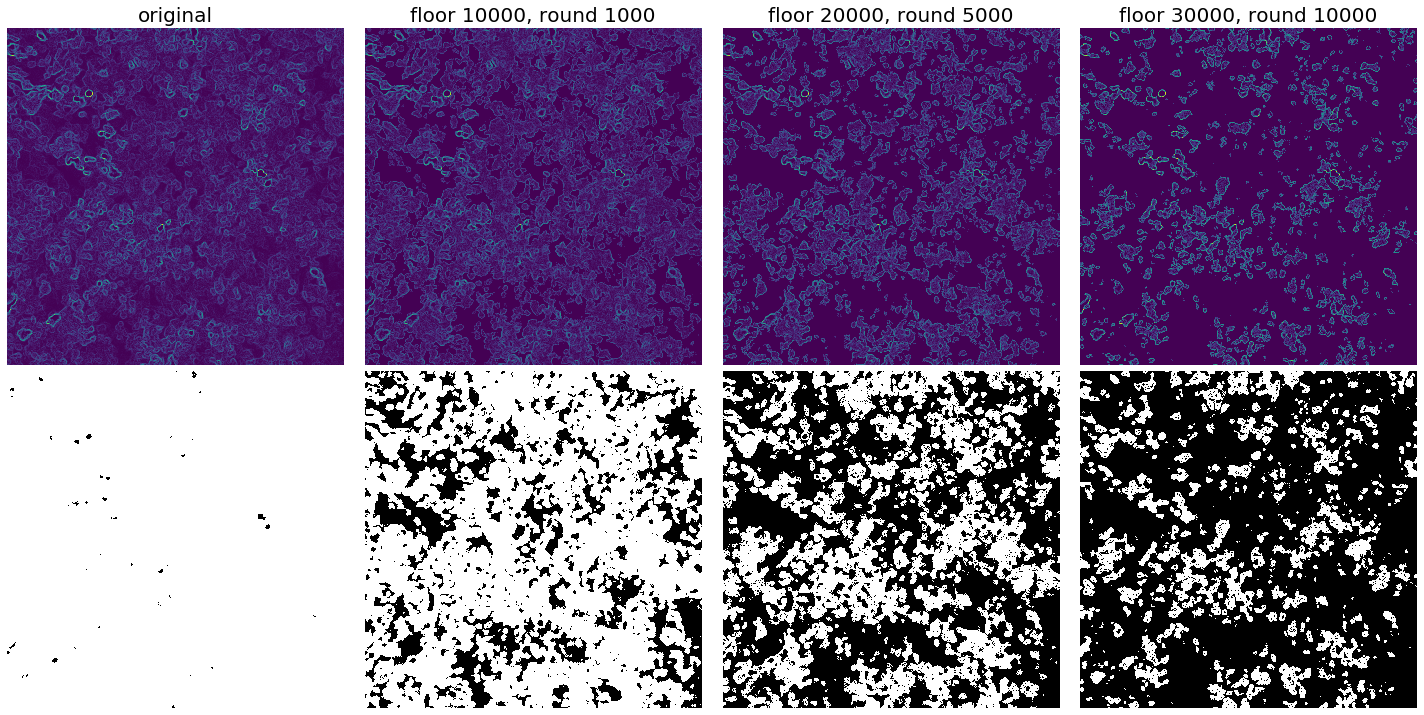

In [ ]:
# display results as two rows moving right with increasing minimum value threshold and interval range

fig, ([ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]) = plt.subplots(nrows=2, ncols=4, figsize=(20, 10),
                                    sharex=True, sharey=True)

ax1.imshow(fig1)
ax1.axis('off')
ax1.set_title('original', fontsize=20)

ax2.imshow(fig2)
ax2.axis('off')
ax2.set_title('floor 10000, round 1000', fontsize=20)

ax3.imshow(fig3)
ax3.axis('off')
ax3.set_title('floor 20000, round 5000', fontsize=20)

ax4.imshow(fig4)
ax4.axis('off')
ax4.set_title('floor 30000, round 10000', fontsize=20)

ax5.imshow(markers1,cmap='gray')
ax5.axis('off')

ax6.imshow(markers2,cmap='gray')
ax6.axis('off')

ax7.imshow(markers3,cmap='gray')
ax7.axis('off')

ax8.imshow(markers4,cmap='gray')
ax8.axis('off')

fig.tight_layout()

plt.show()

see edge clarity improves with higher threshold and intervals. 
could use gaussian filter to reduce intra cell noise
watershed transform
morphology transformation
otsu method
opening
cleared

**region based segmentation with sobel and watershed**

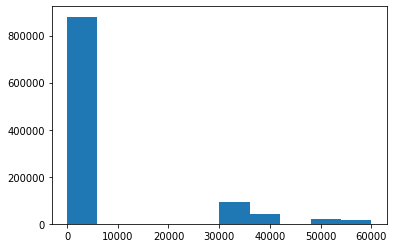

In [ ]:
# region based segmentation
#see distribution of pixel values in threshold im4
fig_array  = flattenMatrix(im4)
plt.hist(fig_array[2], bins=10)
plt.show()

In [ ]:
#define background/forground pixel values
markers = np.zeros_like(im4)
markers[im4 == 0] = 1
markers[im4 > 30000] = 2

sobel_filter = sobel(im4)

In [ ]:
#apply watershed
#flood from markers
#nuclei markers would be sick as fuck!
from skimage.morphology import watershed
segmentation = watershed(sobel_filter, markers)

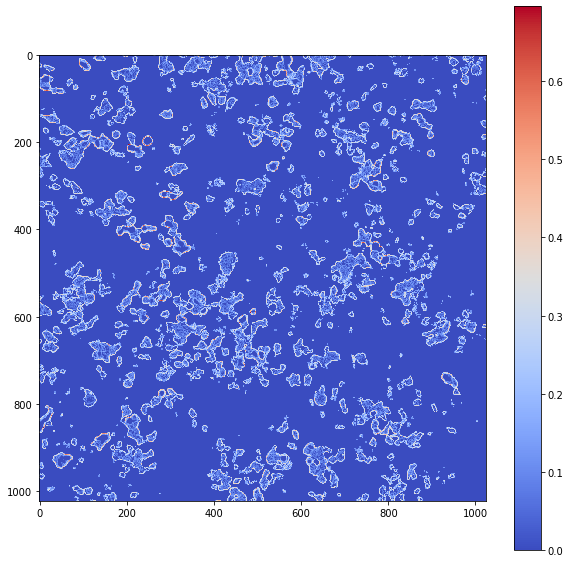

In [ ]:
matrixViz(sobel_filter)

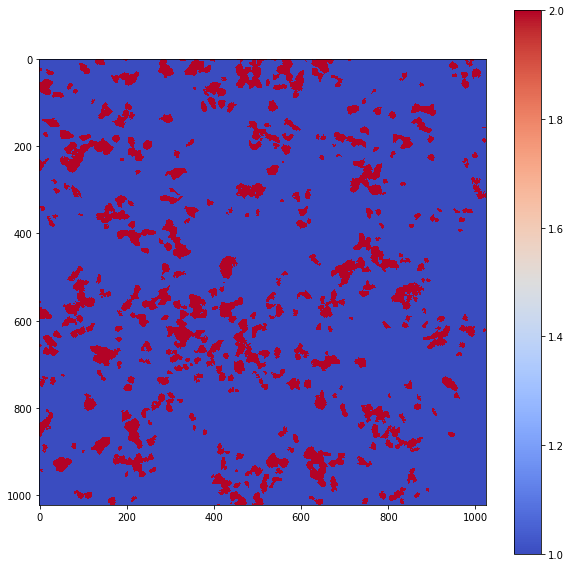

In [ ]:
matrixViz(segmentation)

In [ ]:
#markers should be low enough to detect all cells... edges don't appear to be as clean. probably not shar enough edges for watershed
#could attempt erosion/gaussian transformation

#might be that too much of intra cell is floored to zero. makes finding edge from marker hard

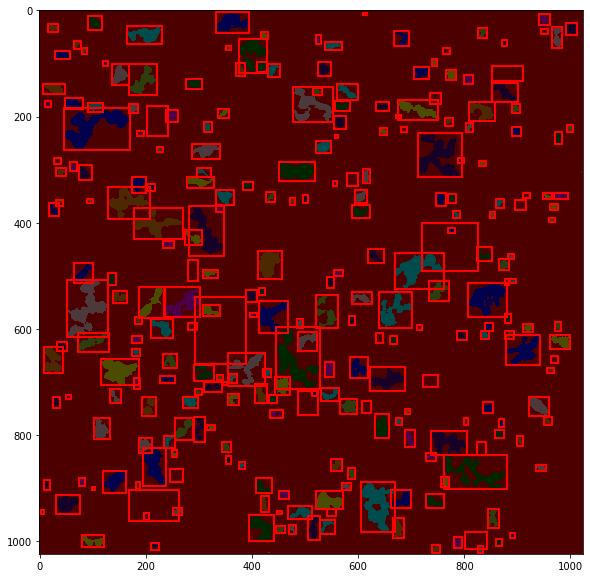

In [ ]:
#labelling script

import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

image = segmentation

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area > 10:
        # draw rectangle around segmented 
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)


plt.show()

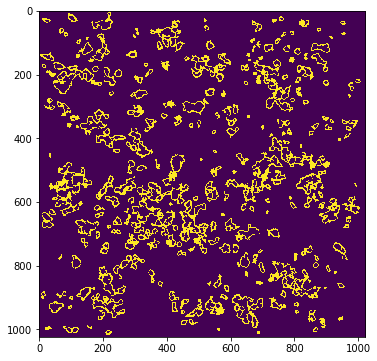

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(cleared)

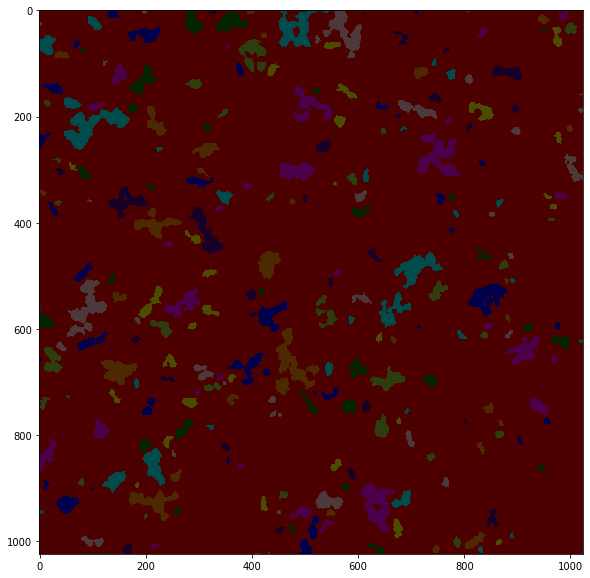

In [ ]:
# label image regions
plt.figure(figsize=(10, 10))
label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=image)
plt.imshow(image_label_overlay)